In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PATH_TO_REF_SET = 'data/hla_ref_set.class_i.csv'
ref_set_class_i = pd.read_csv(PATH_TO_REF_SET,header=None)

In [3]:
ref_set_class_i

,0
0,HLA-A*01:01
1,HLA-A*02:01
2,HLA-A*02:03
3,HLA-A*02:06
4,HLA-A*03:01
5,HLA-A*11:01
6,HLA-A*23:01
7,HLA-A*24:02
8,HLA-A*26:01
9,HLA-A*30:01


In [126]:
class_i_list = ref_set_class_i[0].tolist()

## **Part 1.1**


### Part 1.1.1: Work

In [ ]:
# TODO: Create and train a regression model for predicting pIC50 values for the data in MHCI_Binding_Data.csv
# NOTES: 1. You only need to make predictions for the 27 alleles in hla_ref_set.class_i.csv
#        2. There are several ways to approach this - please refer to the writeup for ideas/suggestions

### Data Prep

In [5]:
# binding data
PATH_TO_MHC1_DATA = 'data/MHCI_Binding_Data.csv'
MHC1_df = pd.read_csv(PATH_TO_MHC1_DATA) 

In [27]:
# filter out records which are not for the 27 listed alleles
MHC1_filtered_df = MHC1_df[MHC1_df['HLA Allele'].isin(class_i_list)]


In [28]:
MHC1_filtered_df

,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129
2,human,HLA-A*01:01,8,FTSFFYRY,1285.000000,5.891097
3,human,HLA-A*01:01,8,KSVFNSLY,1466.000000,5.833866
4,human,HLA-A*01:01,8,RDWAHNSL,1804.675523,5.743601
...,...,...,...,...,...,...
154069,human,HLA-B*58:01,15,GQQRSTLERTSKASL,46728.971960,4.330414
154070,human,HLA-B*58:01,15,QRSTLERTSKASLER,46728.971960,4.330414
154071,human,HLA-B*58:01,15,RALIKTLPRASYSSH,46728.971960,4.330414
154072,human,HLA-B*58:01,17,QFLKFSLPFPFLYKFLL,1973.420365,5.704780


In [8]:
# check how much data we have per allele
MHC1_filtered_df['HLA Allele'].value_counts()

HLA-A*02:01    12160
HLA-A*03:01     7358
HLA-A*11:01     6399
HLA-A*02:03     6303
HLA-A*31:01     5713
HLA-A*02:06     5628
HLA-A*68:02     5545
HLA-A*01:01     4792
HLA-B*07:02     4642
HLA-A*26:01     4535
HLA-B*15:01     4448
HLA-A*68:01     3795
HLA-A*33:01     3597
HLA-B*08:01     3538
HLA-B*40:01     3443
HLA-B*58:01     3350
HLA-A*24:02     3280
HLA-B*35:01     3211
HLA-A*30:01     2925
HLA-B*57:01     2903
HLA-B*51:01     2901
HLA-A*23:01     2641
HLA-B*44:02     2318
HLA-A*30:02     2057
HLA-B*53:01     1720
HLA-B*44:03     1404
HLA-A*32:01     1136
Name: HLA Allele, dtype: int64

In [9]:
# most data is concentrated in 9 and 10 length range
MHC1_filtered_df['peptide_length'].value_counts()

9     83083
10    24300
8      1854
11     1668
13      268
15      206
14      168
12      140
18       27
17       27
30        1
Name: peptide_length, dtype: int64

In [12]:
# create model for length 9 sequences only
def get_n_length_seq(seq,n):
    '''
    Returns a string of the first n characters of the given sequence.
    
    If given sequence has less than n characters, appends J until
    the desired length has been reached, then returns that string.

    Note that J does not code for a natural amino acid.
    '''
    seq_length = len(seq)
    if seq_length < n:
        # append dummy variable J to make it length n
        addition = (n - seq_length) * 'J'
        result = seq + addition
    else:
        # retain the first 9 characters of sequence
        result = seq[:n]
    return result


In [127]:
# test
print(get_n_length_seq('ABCDEFG',10))
print(get_n_length_seq('ABCDEFG',9))

ABCDEFGJJJ
ABCDEFGJJ


In [129]:
# determine 9-length sequence for every row
# MHC1_filtered_df['seq_standard']=MHC1_filtered_df.apply(lambda x: get_n_length_seq(x['sequence'],9),axis=1)

MHC1_filtered_df.loc[:, ('seq_standard')]=MHC1_filtered_df.apply(lambda x: get_n_length_seq(x['sequence'],9),axis=1)

In [130]:
MHC1_filtered_df

,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037,ASFCGSPYJ,65,83,70,67,71,83,80,89,74
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129,LTDFGLSKJ,76,84,68,70,71,76,83,75,74
2,human,HLA-A*01:01,8,FTSFFYRY,1285.000000,5.891097,FTSFFYRYJ,70,84,83,70,70,89,82,89,74
3,human,HLA-A*01:01,8,KSVFNSLY,1466.000000,5.833866,KSVFNSLYJ,75,83,86,70,78,83,76,89,74
4,human,HLA-A*01:01,8,RDWAHNSL,1804.675523,5.743601,RDWAHNSLJ,82,68,87,65,72,78,83,76,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154069,human,HLA-B*58:01,15,GQQRSTLERTSKASL,46728.971960,4.330414,GQQRSTLER,71,81,81,82,83,84,76,69,82
154070,human,HLA-B*58:01,15,QRSTLERTSKASLER,46728.971960,4.330414,QRSTLERTS,81,82,83,84,76,69,82,84,83
154071,human,HLA-B*58:01,15,RALIKTLPRASYSSH,46728.971960,4.330414,RALIKTLPR,82,65,76,73,75,84,76,80,82
154072,human,HLA-B*58:01,17,QFLKFSLPFPFLYKFLL,1973.420365,5.704780,QFLKFSLPF,81,70,76,75,70,83,76,80,70


In [150]:
# split 9 sequence into one column per letter
test = MHC1_filtered_df.head(2)
col_list = ['s1','s2','s3','s4','s5','s6','s7','s8','s9']
test[col_list]=test['seq_standard'].apply(lambda x: pd.Series([ord(char) for char in str(x)]))
test



/opt/anaconda3/envs/CMU-02718-HW5/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037,ASFCGSPYJ,65,83,70,67,71,83,80,89,74
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129,LTDFGLSKJ,76,84,68,70,71,76,83,75,74


In [32]:
# split 9 sequence into one column per letter
# encode letter as ASCII number

col_list = ['s1','s2','s3','s4','s5','s6','s7','s8','s9']
MHC1_filtered_df[col_list]=MHC1_filtered_df.seq_standard.apply(lambda x: pd.Series([ord(char) for char in str(x)]))


/opt/anaconda3/envs/CMU-02718-HW5/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [33]:
MHC1_filtered_df

,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037,ASFCGSPYJ,65,83,70,67,71,83,80,89,74
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129,LTDFGLSKJ,76,84,68,70,71,76,83,75,74
2,human,HLA-A*01:01,8,FTSFFYRY,1285.000000,5.891097,FTSFFYRYJ,70,84,83,70,70,89,82,89,74
3,human,HLA-A*01:01,8,KSVFNSLY,1466.000000,5.833866,KSVFNSLYJ,75,83,86,70,78,83,76,89,74
4,human,HLA-A*01:01,8,RDWAHNSL,1804.675523,5.743601,RDWAHNSLJ,82,68,87,65,72,78,83,76,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154069,human,HLA-B*58:01,15,GQQRSTLERTSKASL,46728.971960,4.330414,GQQRSTLER,71,81,81,82,83,84,76,69,82
154070,human,HLA-B*58:01,15,QRSTLERTSKASLER,46728.971960,4.330414,QRSTLERTS,81,82,83,84,76,69,82,84,83
154071,human,HLA-B*58:01,15,RALIKTLPRASYSSH,46728.971960,4.330414,RALIKTLPR,82,65,76,73,75,84,76,80,82
154072,human,HLA-B*58:01,17,QFLKFSLPFPFLYKFLL,1973.420365,5.704780,QFLKFSLPF,81,70,76,75,70,83,76,80,70


### Data Visualization

In [122]:
from sklearn.decomposition import PCA

def get_allele_data(df,allele):
    '''
    Returns a DataFrame with data only for the given allele.
    '''
    return df[df['HLA Allele'] == allele]


def split_feature_and_target(df):
    '''
    Returns a tuple of (X,y), where X is a DataFrame 
    of the features of the dataset and y is a Series
    of the target.
    
    Features consist only of the sequence columns 
    with individual encoded letters.
    
    Target is the pIC50 column.
    '''
    drop_list = ['species','HLA Allele','peptide_length','sequence','seq_standard','IC50 (nM concentration)', 'pIC50']
    X = df.drop(drop_list,axis=1)
    y = df['pIC50']
    return (X,y)


def visualize_data(df, allele,a1,a2):
#     print(allele,a1,a2)
    X,y = split_feature_and_target(get_allele_data(df,allele))

    # use PCA to visualize data
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    axs[a1,a2].scatter(X_pca[:,0],X_pca[:,1])
    

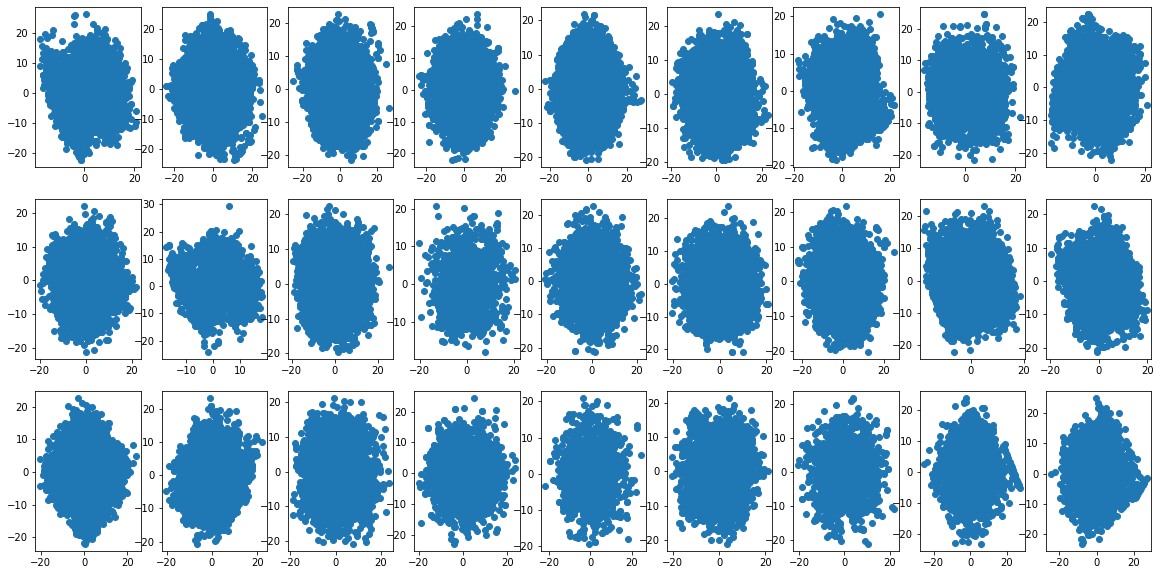

In [152]:
fig, axs = plt.subplots(3,9,figsize=(20,10))

a1 = 0
a2 = 0
for allele in class_i_list:
    if a2 > 8:
        a1 += 1
        a2 = 0
        
    visualize_data(MHC1_filtered_df,allele,a1,a2)
    
    a2 += 1


### Train Regression Model

In [81]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import std


def learn_regression_model(df,allele):
    '''
    Trains a linear regression model on data for
    a given allele, using 5-fold cross validation.
    
    Returns the mean and standard deviation of the
    cross validation scores as a tuple (mean,std_dev).
    '''
    df_allele = get_allele_data(df,allele)
    X,y = split_feature_and_target(df_allele)
    
    # setup crossfold validation
    cv = KFold(n_splits=5, random_state=1, shuffle=True)   
    
    # learn model
    model = LinearRegression()
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv) #, n_jobs=-1
    
    return (mean(scores),std(scores))


In [79]:
# df1 = get_allele_data(MHC1_filtered_df,'HLA-A*01:01')
# split_feature_and_target(df1)
m,s = learn_regression_model(MHC1_filtered_df,'HLA-A*01:01')
print('Mean:',m)
print('Standard Deviation:',s)


(4792, 9)
(4792,)
[0.16128182 0.16607118 0.12221386 0.12311487 0.14200286]
Mean: 0.14293691820430837
Standard Deviation: 0.018411740819341126


In [ ]:
#?? am I supposed to then run the entire model again using .fit(X,y) so that I can use it to predict in 1.3
#?? are the values I'm getting good or bad?

In [86]:


# for each of the 27 alleles, learn a separate regression model
for allele in class_i_list:
    m,s = learn_regression_model(MHC1_filtered_df,allele)
    print(allele,round(m,3),round(s,3),sep='|')


HLA-A*01:01|0.143|0.018
HLA-A*02:01|0.015|0.002
HLA-A*02:03|0.013|0.006
HLA-A*02:06|0.014|0.003
HLA-A*03:01|0.009|0.008
HLA-A*11:01|0.026|0.007
HLA-A*23:01|0.127|0.017
HLA-A*24:02|0.136|0.022
HLA-A*26:01|0.056|0.024
HLA-A*30:01|0.042|0.022
HLA-A*30:02|0.088|0.019
HLA-A*31:01|0.011|0.008
HLA-A*32:01|0.056|0.011
HLA-A*33:01|-0.0|0.005
HLA-A*68:01|0.015|0.007
HLA-A*68:02|0.02|0.001
HLA-B*07:02|0.041|0.013
HLA-B*08:01|0.055|0.014
HLA-B*15:01|0.003|0.002
HLA-B*35:01|0.0|0.006
HLA-B*40:01|0.203|0.023
HLA-B*44:02|0.185|0.021
HLA-B*44:03|0.218|0.029
HLA-B*51:01|0.005|0.009
HLA-B*53:01|-0.011|0.009
HLA-B*57:01|0.043|0.011
HLA-B*58:01|0.035|0.009


In [ ]:
# TODO: Create a table where each row corresponds to one of the MHC I binding affinity models above, and
#       the final column is the Coefficient of determination (ie. R^2) of the model using 5-fold cross validation.  

### Part 1.1.1: Answer

Briefly describe your approach for creating the regression model: **YOUR EXPLANATION HERE**

**Include the table as the output of the cell above or embed it as an image in this cell**

### Part 1.1.2: Work

In [ ]:
PATH_TO_MHC2_DATA = 'MHCII_Binding_Data.csv' # TODO: Change if your path is different
MHC2_df = pd.read_csv(PATH_TO_MHC2_DATA) 

'''
TODO: Create and train a regression model for predicting pIC50 values for the data in MHCII_Binding_Data.csv
NOTES: 1. You only need to make predictions for the 27 alleles in hla_ref_set.class_i.csv
       2. There are several ways to approach this - please refer to the writeup for ideas/suggestions
'''

In [ ]:
'''
TODO: Create a table where each row corresponds to one of the MHC II binding affinity models above, and
      the final column is the Coefficient of determination (ie. R^2) of the model using 5-fold cross validation.  
'''

### Part 1.1.2: Answer

Briefly describe your approach for creating the regression model: **YOUR EXPLANATION HERE**

**Include the table as the output of the cell above or embed it as an image in this cell**

### Part 1.2: Work 

In [ ]:
'''
TIP: The .fasta files usually start with some header describing the meta information. 
     The code below skips the header and joins the lines of the sequence to obtain
     the full protein sequence
'''

PATH_TO_FASTA = 'SARS-CoV2-Spike.fasta' # TODO: Change if your path is different 
with open(PATH_TO_FASTA) as f:
  sequence = ''.join(f.read().split('\n')[1:])

'''
TODO: Split protein sequence from SARS-CoV2-Spike.fasta into overlapping k-mers for your choice of k 

'''


### Part 1.2: Answer

What was the value of k you used to create the overlapping k-mers? **YOUR ANSWER HERE**

### Part 1.3: Work

In [ ]:
'''
TODO: 1. Apply the models you created in part 1.1 to the k-mers you created in part 1.2.  
      2. Store the returned labeled (MHC, peptide) pairs where the label is the predicted pIC50 value
      3. Determine the min, max, mean, median, and std. dev of the predicted pIC50 values for each MHC class
'''

### Part 1.3: Answer

If you would like to manually fill in the table provided in the write-up, please replace the empty table below with a screenshot of your filled in table. Alternatively, you could display the table as the output of the above cell as long as it contains all of the relevant information.

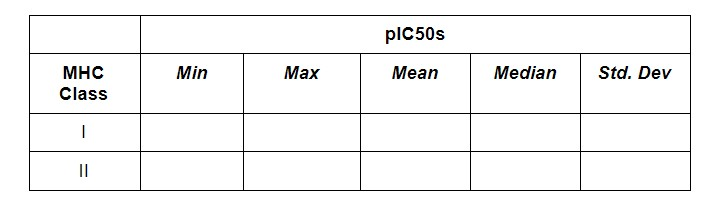

### Part 1.4: Work

In [ ]:
'''
TODO: 1. Devise and implement an algorithm for selecting SARS-CoV-2 peptides from the set you created in part 1.3 that maximizes the ‘allele coverage’
      (Please refer to the write-up for definitions and constraints)
      2. Use your algorithm to compute the values required for the tables in the cell below
'''

### Part 1.4: Answer

Briefly describe the algorithm you devised: **YOUR EXPLANATION HERE**

If you would like to manually fill in the tables provided in the write-up, please replace the empty tables below with a screenshot of your filled in table. Alternatively, you could display the tables as the output of above cells as long as they contain all of the relevant information.

**MHC I Alleles**

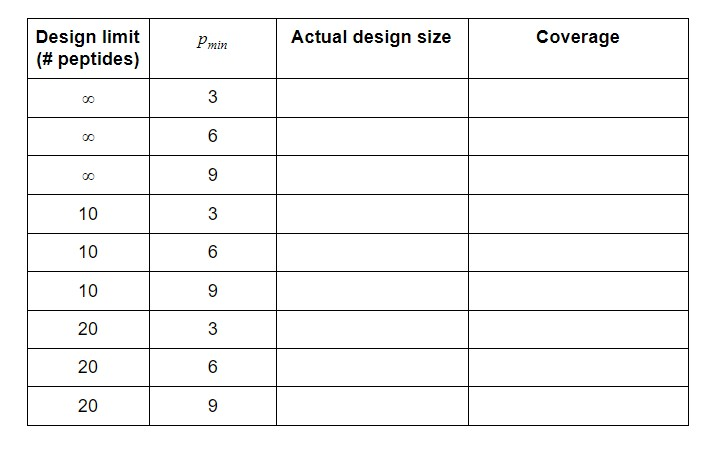

**MHC II Alleles**

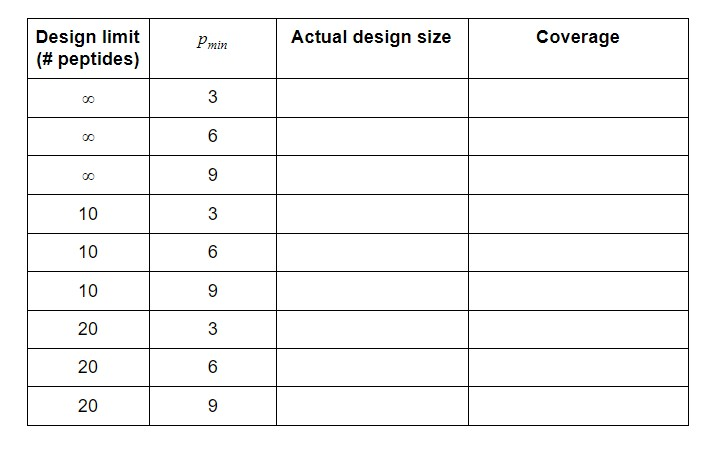


### Part 1.5: Work

In [ ]:
'''
TODO: 1. Determine criteria for selecting 20 peptides for your vaccine
        (You do not need to have an equal number of peptides ‘covering’ MHC I and MHC II alleles)
      2. Apply this criteria to obtain the required information for table in the cell below.      
'''

### Part 1.5: Answer

Explain the criteria you used to select peptides: **YOUR EXPLANATION HERE**

What is the expected coverage of your design? **YOUR ANSWER HERE**

If you would like to manually fill in the table provided in the write-up, please replace the empty table below with a screenshot of your filled in table. Alternatively, you could display the table as the output of above cell as long as it contains all of the relevant information.

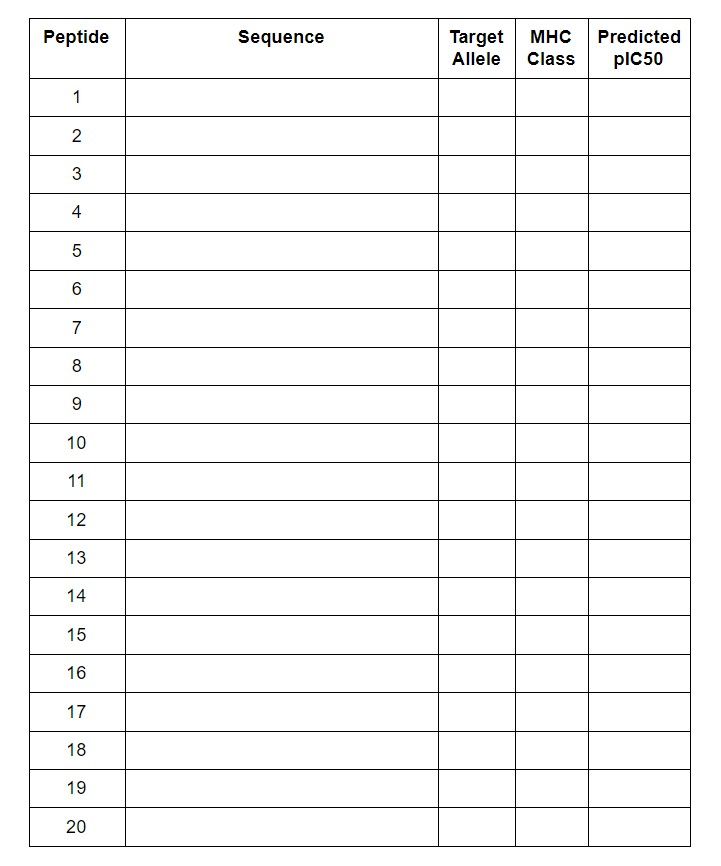